# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.0048],
         [0.4444]]),
 tensor([[1.0000e+00, 1.0048e+00, 5.0478e-01, 1.6906e-01, 4.2467e-02, 8.5340e-03,
          1.4291e-03, 2.0513e-04, 2.5764e-05, 2.8763e-06, 2.8900e-07, 2.6398e-08,
          2.2104e-09, 1.7084e-10, 1.2261e-11, 8.2130e-13, 5.1576e-14, 3.0483e-15,
          1.7016e-16, 8.9985e-18],
         [1.0000e+00, 4.4442e-01, 9.8753e-02, 1.4629e-02, 1.6253e-03, 1.4447e-04,
          1.0700e-05, 6.7935e-07, 3.7739e-08, 1.8635e-09, 8.2819e-11, 3.3460e-12,
          1.2392e-13, 4.2362e-15, 1.3448e-16, 3.9842e-18, 1.1066e-19, 2.8930e-21,
          7.1428e-23, 1.6707e-24]]),
 tensor([5.5840, 5.1512]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.999271   1.2023467 -3.3855863  5.618878 ]]


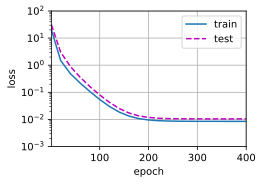

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.609593 4.033575]]


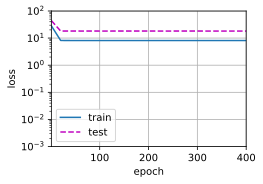

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9902058e+00  1.3019485e+00 -3.3366165e+00  5.0745234e+00
  -1.6597036e-01  1.4335096e+00  1.3934827e-01  1.4873333e-01
  -8.1965379e-02 -1.7380498e-01  1.3361640e-01 -2.2005777e-01
  -1.1247576e-01  1.6846126e-01  1.5431297e-01  1.7628415e-01
   1.1493922e-01  1.2356597e-01 -3.1936557e-03 -1.8990891e-01]]


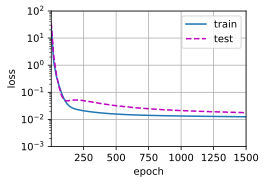

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)